In [1]:
#Hey I've added this so we can see properly SQL Views from Spark (Simon)
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys


os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [4]:
#First: filter the restaurant
biz_df = sqlContext.read.json("original_data/business.json")

In [5]:
biz_df.createOrReplaceTempView('biz_table')

In [6]:
biz_res = sqlContext.sql('SELECT * FROM biz_table WHERE categories LIKE \'%Restaurants%\'')
biz_res.show()

+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|              city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|30 Eglinton Avenue W|[,, u'full_bar', ...|QXAEGFB4oINsVuTFx...|Specialty Food, R...|       Mississauga|[9:0-1:0, 9:0-0:0...|      1|43.6054989743|  -79.652288909|Emerald Chinese R...|    L5R 3E7|         128|  2.5|   ON|
|10110 Johnston Rd...|[,, u'beer_and_wi...|gnKjwL_1w79qoiV3I...|Sushi Bars, Resta...|         Charlotte|[17:30-2

In [7]:
biz_res.createOrReplaceTempView('biz_res_table')

In [8]:
def filter_res(parent,filename,key):
    df = sqlContext.read.json("original_data/"+filename)
    table_name=filename[:-5]+'_table'
    df.createOrReplaceTempView(filename[:-5]+'_table')
    sqlquery = 'SELECT c.* FROM {} c LEFT JOIN {} b ON c.{} = b.{} WHERE b.{} IS NOT NULL'.format(table_name,parent,key,key,key)
    print(sqlquery)
    df_res=sqlContext.sql(sqlquery)
    return df_res

In [9]:
checkin_res = filter_res('biz_res_table','checkin.json','business_id')
review_res = filter_res('biz_res_table','review.json','business_id')
review_res.createOrReplaceTempView('review_res_table')
tip_res = filter_res('review_res_table','tip.json','user_id') #since tip is on individual level, match them with users
user_res = filter_res('review_res_table','user.json','user_id') 

SELECT c.* FROM checkin_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM review_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM tip_table c LEFT JOIN review_res_table b ON c.user_id = b.user_id WHERE b.user_id IS NOT NULL
SELECT c.* FROM user_table c LEFT JOIN review_res_table b ON c.user_id = b.user_id WHERE b.user_id IS NOT NULL


In [10]:
#sample  business into dev_set and test_set
import pyspark.sql.functions as f
review_res = review_res.withColumn('index_1', f.monotonically_increasing_id())
review_res.createOrReplaceTempView('review_res_table')
sqlquery = 'SELECT * FROM review_res_table ORDER BY RAND(42) LIMIT {}'.format(1000)
review_sample = sqlContext.sql(sqlquery)
review_sample.createOrReplaceTempView('review_sample_table')

sqlquery = 'SELECT a.* FROM review_res_table a LEFT JOIN review_sample_table b ON a.index_1 = b.index_1 WHERE b.index_1 IS NULL '
review_train = sqlContext.sql(sqlquery)
# 


In [11]:
#sample 500 into dev_set and 500 into test_set
from pyspark.sql.functions import desc
review_sample = review_sample.withColumn('index_2', f.monotonically_increasing_id())
review_dev = review_sample.limit(500)
review_test = review_sample.sort(desc("index_2")).limit(500)

In [12]:
review_dev.toPandas().to_csv('filtered_data/review_dev.csv',header = 'true')
review_test.toPandas().to_csv('filtered_data/review_test.csv',header = 'true')

In [13]:
review_dev.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+------------+-------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|     index_1|index_2|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+------------+-------+
|wArcCMVnrl_tc9MUL...|   0|2014-05-02 14:22:05|    0|ZtAnERu9OwjIO4ug0...|  3.0|We loved the atmo...|     0|g60bxO0B2I6os1iCX...|223338344704|      0|
|YlwJYpBWa-oL0byTV...|   0|2018-11-03 19:57:36|    0|8b_S0_FDF0zx3sELm...|  1.0|SO SLOW! Mostly E...|     0|MWKALAdfSvzFE_LEj...|335007509918|      1|
|8mIrX_LrOnAqWsB5J...|   0|2016-10-23 19:18:39|    0|IF9A7iGnOLhF3aSlx...|  4.0|So much fun for a...|     0|93NLI_oDOFpDRmgxx...| 17179951328|      2|
|M-bM5y8qdE-Z3mfZe...|   1|2011-03-29 05:07:26|    0|bebMts1G_tBse6zra...|  4.0|I like this pl

In [14]:
#select the record from business checkin tip and users based on business_id(first two), user_id(last two)
setname=['_train','_dev','_test']
def filter_sample(parent,child,key): #parent:the reference table, child: the table needs filtering
    parent.createOrReplaceTempView('p')
    child.createOrReplaceTempView('c') #child xx_res
    sqlquery = 'SELECT c.* FROM c LEFT JOIN p ON c.{} = p.{} WHERE p.{} IS NOT NULL'.format(key,key,key)
    df=sqlContext.sql(sqlquery)
    return df
for i in range(3):
    globals()['biz'+setname[i]] = filter_sample(globals()['review'+setname[i]],biz_res,'business_id')
    globals()['checkin'+setname[i]] = filter_sample(globals()['review'+setname[i]],checkin_res,'business_id')
    globals()['tip'+setname[i]] = filter_sample(globals()['review'+setname[i]],tip_res,'user_id')
    globals()['user'+setname[i]] = filter_sample(globals()['review'+setname[i]],user_res,'user_id')

In [15]:
biz_test.show()

+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|           city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|322 Adelaide Stre...|[,, u'beer_and_wi...|c35qzLN6ItDpVIoj2...|Soup, Restaurants...|        Toronto|[11:0-22:0, 11:0-...|      1|   43.6475853|    -79.3920316|          Ravi Soups|    M5V 1R1|         332|  4.5|   ON|
|     2004 Crocker Rd|[,,, {'touristy':...|nYvBZYg9rfqWFTYux...|Mexican, Bars, Re...|       Westlake|[11:0-23:0, 11:0-...|  

In [16]:
# aggregate the mean star each business and individual
df_biz_stars=biz_res.select('business_id','stars','review_count') # aggregate business
ind_stars=review_res.select('user_id','stars','business_id') #aggregate ind
mapped_test = ind_stars.rdd.map(lambda x: (x[0],x[1]))
ind_total_starts = mapped_test.reduceByKey(lambda a,b:a+b)
mapped_test = ind_stars.rdd.map(lambda x: (x[0],1))
ind_total_review =  mapped_test.reduceByKey(lambda a,b:a+b)



In [17]:

# convert to spark data frame
df_ind_total_starts = ind_total_starts.toDF(["user_id", "total_stars"])
df_ind_total_review = ind_total_review.toDF(["user_id", "total_reviews"])
df_ind_stars = df_ind_total_starts.join(df_ind_total_review, df_ind_total_starts.user_id == df_ind_total_review.user_id)
df_ind_stars = df_ind_stars.withColumn('avg_stars' , df_ind_stars.total_stars/df_ind_stars.total_reviews)
df_ind_stars.show()
df_biz_stars.show()

+--------------------+-----------+--------------------+-------------+------------------+
|             user_id|total_stars|             user_id|total_reviews|         avg_stars|
+--------------------+-----------+--------------------+-------------+------------------+
|-0Ji0nOyFe-4yo8BK...|        4.0|-0Ji0nOyFe-4yo8BK...|            1|               4.0|
|-1KKYzibGPyUX-Mwk...|        4.0|-1KKYzibGPyUX-Mwk...|            1|               4.0|
|-1zQA2f_syMAdA04P...|       10.0|-1zQA2f_syMAdA04P...|            2|               5.0|
|-2Pb5d2WBPtbyGT_b...|        5.0|-2Pb5d2WBPtbyGT_b...|            1|               5.0|
|-3bsS2i9xqjNnIA1f...|        5.0|-3bsS2i9xqjNnIA1f...|            2|               2.5|
|-3i9bhfvrM3F1wsC9...|       34.0|-3i9bhfvrM3F1wsC9...|            9|3.7777777777777777|
|-47g7LR58tpHlm7Bm...|        5.0|-47g7LR58tpHlm7Bm...|            1|               5.0|
|-4Anvj46CWf57KWI9...|        3.0|-4Anvj46CWf57KWI9...|            1|               3.0|
|-4xyc3OgPwrLshmqH...

In [18]:
df_biz_stars=df_biz_stars.toPandas()
df_ind_stars=df_ind_stars.toPandas()
df_ind_stars = df_ind_stars.loc[:,~df_ind_stars.columns.duplicated()]

In [19]:
df_ind_stars.describe()

,total_stars,total_reviews,avg_stars
count,1.148098e+06,1.148098e+06,1.148098e+06
mean,1.360401e+01,3.659691e+00,3.676724e+00
std,4.257595e+01,1.159263e+01,1.380367e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.000000e+00,1.000000e+00,3.000000e+00
50%,5.000000e+00,1.000000e+00,4.000000e+00
75%,1.100000e+01,3.000000e+00,5.000000e+00
max,8.428000e+03,2.656000e+03,5.000000e+00


In [20]:
import pandas as pd
from pyspark.sql import SparkSession
from snorkel.labeling import PandasLFApplier,LFAnalysis
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()
pd_dev = pd.read_csv("review_dev_labelled.csv",header=0, index_col=0)


In [21]:
pd_dev.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,index_1,index_2,label
#,,,,,,,,,,,,
0,XFhnPpO2x0nS-lVkqZSf_Q,1,14/02/2017 16:50,0,o6VZ0cQEfIBvGW15uvFPCQ,2,I knew it was a kitschy place when I found it ...,0,dk5yqirSwDH7Cpp52NdhUA,1.080000e+12,0,1
1,SRCepG6PbMvwKcfIUjk8bQ,0,11/12/2015 02:47,0,PBy3gB_D1xEiBJDrwvYXAQ,2,"Average place, but I wish I would've read revi...",0,xmtWxX67wF7afssQRcVqiw,7.300000e+11,1,1
2,pneBBrIzd3SCbbglYRTBZA,2,15/05/2015 19:18,0,AeyK7AEtbfubw1aD0cAz1g,4,This is a great outside poolside place for del...,4,X4k8ugJaihHVLHq32rNTwQ,4.900000e+11,2,0
3,8enR8Wc0ot9L41JY1FxMlA,0,15/09/2017 13:17,0,Vkx4AUppu9A7DL3AI3aBVw,5,We took shelter at the Andaz from hurricane Ir...,0,Xpl0z24sZ-zJ6klgVSj_zQ,1.150000e+12,3,0
4,HhVmDybpU7L50Kb5A0jXTg,0,06/02/2016 02:12,0,2GtcaGkq5nAxBvKZpt-eTg,3,Had the burgers on a Carnival cruise ship a co...,0,9T39fu4au232kl25RqO6Ow,9.960000e+11,4,1


In [22]:
df_dev = spark.createDataFrame(pd_dev)

In [23]:
pd_dev.user_id.value_counts()

#NAME?                    3
jlu4CztcSxrKx56ba1a5AQ    2
Y9OQzttigHxtqtEbdFLTCA    2
LNNQSUtoYEtf0AsGQRwfJQ    1
Ao-6FYE29-I8WwPg67806A    1
                         ..
soq8qWSETePYVaCK7vSS6A    1
DK57YibC5ShBmqQl97CKog    1
xwZ0oo5gfwjFYQcubAeKLw    1
X58khvVmj2R8_H6Rn4kOYw    1
rPOFJ7sKsJ_YhDDz-Oy70w    1
Name: user_id, Length: 496, dtype: int64

In [24]:
temp=pd_dev.merge(df_ind_stars, on= 'user_id', how='left')
temp.groupby('label')['avg_stars'].agg('mean')
def q(x):
            return x.quantile(0.85)
temp.groupby('label')['total_reviews'].agg('median')
temp.groupby('label')['total_reviews'].agg(q)

label
0    4.037817
1    3.120072
Name: avg_stars, dtype: float64

label
0     8.0
1    10.0
Name: total_reviews, dtype: float64

label
0    52.6
1    86.0
Name: total_reviews, dtype: float64

In [55]:
#merge user_dev.jointime 
reduced_user = user_res.select('user_id','yelping_since')
reduced_user_pd= reduced_user.toPandas().drop_duplicates(subset=['user_id'])
reduced_user_pd.head()


,user_id,yelping_since
0,-0Ji0nOyFe-4yo8BK4aRLA,2009-05-15 19:50:34
1,-1KKYzibGPyUX-MwkBTlrg,2009-08-07 13:42:19
2,-1zQA2f_syMAdA04PUWNNw,2014-06-22 02:44:41
4,-2Pb5d2WBPtbyGT_be6NDQ,2009-04-29 14:35:45
5,-3bsS2i9xqjNnIA1fRnzIQ,2012-04-10 22:25:58


In [56]:
reduced_user_pd['date']=reduced_user_pd['yelping_since'].map(lambda x:int(x[0:4]))
reduced_user_pd.head()

,user_id,yelping_since,date
0,-0Ji0nOyFe-4yo8BK4aRLA,2009-05-15 19:50:34,2009
1,-1KKYzibGPyUX-MwkBTlrg,2009-08-07 13:42:19,2009
2,-1zQA2f_syMAdA04PUWNNw,2014-06-22 02:44:41,2014
4,-2Pb5d2WBPtbyGT_be6NDQ,2009-04-29 14:35:45,2009
5,-3bsS2i9xqjNnIA1fRnzIQ,2012-04-10 22:25:58,2012


In [59]:
temp=pd_dev.merge(reduced_user_pd, on= 'user_id', how='left')
temp.groupby('label')['date_y'].agg('mean')
def q(x):
            return x.quantile(0.40)
temp.groupby('label')['date_y'].agg(q)
temp.describe()

label
0    2012.575439
1    2012.886792
Name: date_y, dtype: float64

label
0    2012.0
1    2012.0
Name: date_y, dtype: float64

,cool,funny,stars,useful,index_1,index_2,label,date_y
count,500.00000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,497.000000
mean,0.57800,0.444000,3.700000,1.142000,8.374544e+11,249.500000,0.428000,2012.708249
std,2.69266,1.953073,1.403545,4.068777,4.993660e+11,144.481833,0.495284,2.542659
min,0.00000,0.000000,1.000000,0.000000,1.224900e+04,0.000000,0.000000,2004.000000
25%,0.00000,0.000000,3.000000,0.000000,3.847500e+11,124.750000,0.000000,2011.000000
50%,0.00000,0.000000,4.000000,0.000000,8.245000e+11,249.500000,0.000000,2013.000000
75%,1.00000,0.000000,5.000000,1.000000,1.242500e+12,374.250000,1.000000,2015.000000
max,55.00000,37.000000,5.000000,83.000000,1.710000e+12,499.000000,1.000000,2018.000000


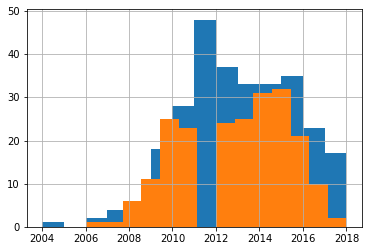

In [64]:
temp[temp['label']==0]['date_y'].hist(bins=14)
temp[temp['label']==1]['date_y'].hist(bins=14)



In [49]:
type(dict_user_date['5JAS5QodnrAeZjCncVx8fQ'])

int

In [65]:
#Try to apply Labeling function
import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
#from snorkel.labeling import ,LFAnalysis
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

@labeling_function()
def low_star(x):
    return POSITIVE if x.stars<4 else ABSTAIN

dict_biz_stars = dict(zip(df_biz_stars.business_id, df_biz_stars.stars))
@labeling_function(resources=dict(dict_biz_stars=dict_biz_stars))
def low_star_biz(x,dict_biz_stars):
    if x.business_id!='#NAME?':
        a = dict_biz_stars[x.business_id]
    else:
        a = 0
    return POSITIVE if (x.stars<5 and a <x.stars ) else ABSTAIN
com_info = zip(df_ind_stars.avg_stars, df_ind_stars.total_reviews)
dict_ind_stars = dict(zip(df_ind_stars.user_id, com_info ))
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def high_star_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return NEGATIVE if (x.stars > a) else ABSTAIN

@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def picky_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return POSITIVE if a <3.5 else ABSTAIN
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def talktive_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            b = dict_ind_stars[x.user_id][1]
        else:
            b = 0 
    else:
        b = 0
    return POSITIVE if b > 86  else ABSTAIN

dict_user_date = dict(zip(reduced_user_pd.user_id, reduced_user_pd.date))
@labeling_function(resources=dict(dict_user_date=dict_user_date))
def date_ind(x,dict_user_date):
    if x.user_id!='#NAME?':
        if x.user_id in dict_user_date.keys():
            b = dict_user_date[x.user_id]
        else:
            b = 3000 
    else:
        b = 3000
    return NEGATIVE if (b==2011 or b>=2016)  else ABSTAIN
'''
put your labeling function here
'''

# Build label matrix
lfs = [low_star,low_star_biz,high_star_ind,picky_ind,talktive_ind,date_ind]
applier = SparkLFApplier(lfs)
L_dev = applier.apply(df_dev.rdd)
g_label =np.array(df_dev.select('label').collect())
LFAnalysis(L_dev, lfs).lf_summary(g_label) 


'''
The following part is for Combining Labeling Function Outputs with the Label Model
You dont need to use the following part the evaluate the performance of your development set
Only use the following part when the number of lfs is greater or equal to three
'''
# # Train label model 
# label_model = LabelModel(cardinality=2)
# label_model.fit(L)

# # Generate training labels
# y_prob = label_model.predict_proba(L_dev)[:, 1] 
# y_prob_sql_array = F.array([F.lit(y) for y in y_prob])
# #data_labeled = df_dev.withColumn("y_prob", y_prob_sql_array)

'\nput your labeling function here\n'

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
low_star,0,[1],0.356,0.272,0.098,160,18,0.898876
low_star_biz,1,[1],0.104,0.084,0.072,22,30,0.423077
high_star_ind,2,[0],0.456,0.274,0.214,187,41,0.820175
picky_ind,3,[1],0.352,0.352,0.202,115,61,0.653409
talktive_ind,4,[1],0.120,0.118,0.082,31,29,0.516667
date_ind,5,[0],0.294,0.224,0.164,89,58,0.605442


'\nThe following part is for Combining Labeling Function Outputs with the Label Model\nYou dont need to use the following part the evaluate the performance of your development set\nOnly use the following part when the number of lfs is greater or equal to three\n'